In [2]:
import numpy as np
import pandas as pd
import statistics
import scipy.stats as ss
import matplotlib.pyplot as plt


In [3]:
# Load the data from the second sheet
file_path = "Data_v2_2024.06.11 - Copy.xlsx"
df = pd.read_excel(file_path, sheet_name=1, header=[2])
df.head()

,Security,GDBR10 Date,GDBR10 Index,GTFRF10Y Date,GTFRF10Y Govt,GTNLG10Y Date,GTNLG10Y Govt,GTATS10Y Date,GTATS10Y Govt,GTFIM10Y Date,...,Unnamed: 36,GBTPGR10 Date.1,Unnamed: 38,GTESP10Y Date.1,Unnamed: 40,GTPTE10Y Date.1,Unnamed: 42,GIGB10YR Date.1,Unnamed: 44,USGG10YR Date.1
0,NaN,2000-01-03,5.478,2000-01-03,5.593,2000-01-03,5.612,2000-01-03,5.681,2000-01-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,2000-01-04,5.492,2000-01-04,5.611,2000-01-04,5.631,2000-01-04,5.699,2000-01-04,...,NaN,NaN,NaN,NaN,NaN,1 Missing date(s),NaN,NaN,NaN,NaN
2,NaN,2000-01-05,5.516,2000-01-05,5.643,2000-01-05,5.646,2000-01-05,5.722,2000-01-05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,2000-01-06,5.545,2000-01-06,5.678,2000-01-06,5.710,2000-01-06,5.776,2000-01-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,2000-01-07,5.443,2000-01-07,5.567,2000-01-07,5.609,2000-01-07,5.681,2000-01-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
EA_yields_daily = pd.read_excel(file_path, sheet_name=2, header=[14], usecols=[1,12])
EA_yields_daily.rename(columns={'DATE': 'EA10Y Date', 'Par yield curve rate, 10-year maturity - Government bond, nominal, all issuers all ratings included - Euro area (changing composition) (YC.B.U2.EUR.4F.G_N_C.SV_C_YM.PY_10Y)': 'EA10Y Yield'}, inplace=True)
EA_yields_daily.head()

,EA10Y Date,EA10Y Yield
0,2004-09-06,4.156516
1,2004-09-07,4.157714
2,2004-09-08,4.178160
3,2004-09-09,4.113731
4,2004-09-10,4.071960


In [5]:
# Extract columns for each country
countries = ['GDBR10', 'GTFRF10Y', 'GTNLG10Y', 'GTATS10Y', 'GTFIM10Y', 'GTBEF10Y', 'GBTPGR10', 'GTESP10Y', 'GTPTE10Y', 'GIGB10YR', 'USGG10YR']
date_columns = [f'{country} Date' for country in countries]
yield_columns = [col for col in df.columns if 'Govt' in col or 'Index' in col]

# Create a new DataFrame for processing
data = pd.DataFrame()

for date_col, yield_col in zip(date_columns, yield_columns):
    temp_df = df[[date_col, yield_col]].dropna()
    temp_df.columns = ['Date', 'Bond_Yield']
    temp_df['Country'] = yield_col.split()[0]
    temp_df['Date'] = pd.to_datetime(temp_df['Date'])
    data = pd.concat([data, temp_df])

data = data.set_index(['Country', 'Date'])

In [6]:
data = data.reset_index()
data

,Country,Date,Bond_Yield
0,GDBR10,2000-01-03,5.4780
1,GDBR10,2000-01-04,5.4920
2,GDBR10,2000-01-05,5.5160
3,GDBR10,2000-01-06,5.5450
4,GDBR10,2000-01-07,5.4430
...,...,...,...
69144,USGG10YR,2024-05-20,4.4433
69145,USGG10YR,2024-05-21,4.4120
69146,USGG10YR,2024-05-22,4.4218
69147,USGG10YR,2024-05-23,4.4767


In [7]:
# Check if the correct columns exist
if 'Country' not in data.columns or 'Date' not in data.columns or 'Bond_Yield' not in data.columns:
    print("Columns 'Country', 'Date', and 'Bond_Yield' must exist in the DataFrame.")
else:
    # Filter the DataFrame to keep only the 10-year maturities for the 10 euro countries
    ten_year_maturities = ['GDBR10', 'GTFRF10Y', 'GTNLG10Y', 'GTATS10Y', 'GTFIM10Y', 'GTBEF10Y', 'GBTPGR10', 'GTESP10Y', 'GTPTE10Y', 'GIGB10YR', 'EA10Y']
    data_10y = data[data['Country'].isin(ten_year_maturities)]
    
    # Pivot the data to have dates as rows and countries as columns
    data_pivot = data_10y.pivot(index='Date', columns='Country', values='Bond_Yield')
    
    # Calculate the average bond yield across the countries for each day
    average_yield_per_day = data_pivot.mean(axis=1)
    
    # Reset index to have 'Date' as a column for better readability
    average_yield_per_day = average_yield_per_day.reset_index()
    average_yield_per_day.columns = ['Date', 'Average_Bond_Yield']
    
    # Filter the data to include only dates up to 2004-09-05
    filtered_data = average_yield_per_day[average_yield_per_day['Date'] <= '2004-09-05']

    # Load the EA daily yields data
    EA_yields_daily = pd.read_excel(file_path, sheet_name=2, header=[14], usecols=[1,12])
    EA_yields_daily.rename(columns={'DATE': 'EA10Y Date', 'Par yield curve rate, 10-year maturity - Government bond, nominal, all issuers all ratings included - Euro area (changing composition) (YC.B.U2.EUR.4F.G_N_C.SV_C_YM.PY_10Y)': 'EA10Y Yield'}, inplace=True)
    
    # Convert 'EA10Y Date' to datetime to align with the 'Date' column in filtered_data
    EA_yields_daily['EA10Y Date'] = pd.to_datetime(EA_yields_daily['EA10Y Date'])
    
    # Rename columns in filtered_data to match EA_yields_daily for concatenation
    filtered_data.rename(columns={'Date': 'EA10Y Date', 'Average_Bond_Yield': 'EA10Y Yield'}, inplace=True)
    
    # Concatenate the two DataFrames
    combined_data = pd.concat([filtered_data, EA_yields_daily], ignore_index=True)
    
    # Sort the combined data by date
    combined_data = combined_data.sort_values(by='EA10Y Date').reset_index(drop=True)
    
    # Display the first few rows of the resulting combined DataFrame
    print(combined_data.head())

    # Optionally, save the combined data to a new Excel file
    #combined_data.to_excel('combined_average_yield_per_day.xlsx', index=False)

  EA10Y Date  EA10Y Yield
0 2000-01-03       5.6526
1 2000-01-04       5.6610
2 2000-01-05       5.6989
3 2000-01-06       5.7429
4 2000-01-07       5.6396


c:\Users\admin\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [8]:
# Filter the data to include only dates up to 2004-09-05
filtered_data = average_yield_per_day[average_yield_per_day['Date'] <= '2004-09-05']

# Display the first few rows of the resulting DataFrame
print(filtered_data.head())

# Optionally, save the filtered data to a new Excel file
filtered_data.to_excel('filtered_ECB_10YR_average_yield_per_day.xlsx', index=False)

        Date  Average_Bond_Yield
0 2000-01-03              5.6526
1 2000-01-04              5.6610
2 2000-01-05              5.6989
3 2000-01-06              5.7429
4 2000-01-07              5.6396


In [9]:
average_yield_per_day.to_excel("ECB_10YR_average_yield_per_day.xlsx", index=False)

In [10]:
combined_data.rename(columns={'EA10Y Date': 'Date', 'EA10Y Yield': 'Average 10Y Bond Yield (10 EU Countries)'}, inplace=True)
combined_data.to_excel('ECB_10YR_combined_average_yield_per_day.xlsx', index=False)

In [13]:
combined_data

,Date,Average 10Y Bond Yield (10 EU Countries)
0,2000-01-03,5.652600
1,2000-01-04,5.661000
2,2000-01-05,5.698900
3,2000-01-06,5.742900
4,2000-01-07,5.639600
...,...,...
6266,2024-06-03,3.160845
6267,2024-06-04,3.090801
6268,2024-06-05,3.075257
6269,2024-06-06,3.132258


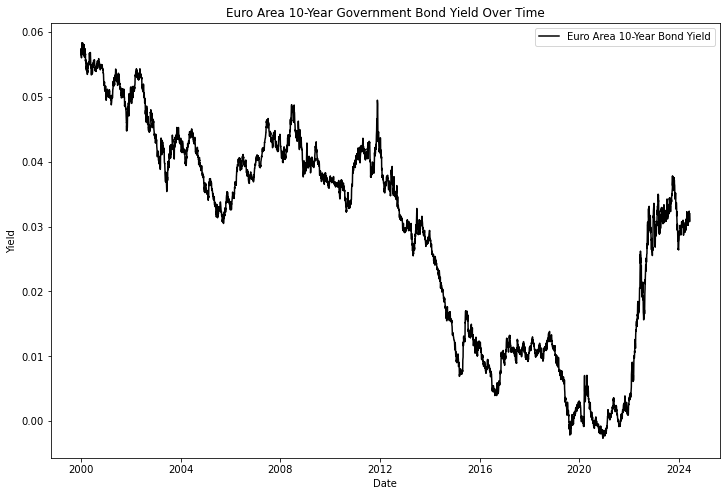

In [18]:
# Creating the plot
plt.figure(figsize=(12, 8))
plt.plot(combined_data['Date'],combined_data['Average 10Y Bond Yield (10 EU Countries)']/100, label='Euro Area 10-Year Bond Yield', c='black')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Yield')
plt.title('Euro Area 10-Year Government Bond Yield Over Time')

# Adding legend
plt.legend()

# Display the plot
plt.show()